# **"Exploratory Data Analysis of Supermarket Sales"**

## This report presents a comprehensive exploratory data analysis (EDA) of supermarket sales records.
## The primary objective is to uncover sales trends, customer behavior patterns, and product performance across various cities and store branches.

##By examining key factors including revenue, product lines, payment methods, and customer demographics, we aim to generate actionable insights that support strategic business decisions and improve overall performance.

## **Project Overview and Global Configuration**

In [ ]:
# -*- coding: utf-8 -*-
"""
Project: Supermarket Sales - Exploratory Data Analysis
Author: Matheus Bittencourt
Description: This notebook performs a structured EDA to identify sales trends,
             customer behavior patterns, and product performance metrics.
"""

# Global configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## **Version Control and Reproducibility Notes**

In [ ]:
# Version control note (manual)
__version__ = "1.0"
__last_updated__ = "2025-08-13"
__data_source__ = "GitHub RAW"

# For reproducibility
SEED = 42
np.random.seed(SEED)

print(f"Project version: {__version__} | Last updated: {__last_updated__}")

Project version: 1.0 | Last updated: 2025-08-13


# **Data Intake (from GitHub RAW)**

In [ ]:


import pandas as pd

DATA_URL = "https://raw.githubusercontent.com/Matheusb009/supermarket-sales-eda/refs/heads/main/supermarket_sales_data.xlsx.csv"

def load_dataset(url: str) -> pd.DataFrame:
    """
    Load dataset from GitHub RAW.
    Tries Excel (openpyxl) first; falls back to CSV with automatic delimiter inference.
    """
    try:
        df = pd.read_excel(url, engine="openpyxl")
        fmt = "Excel"
    except Exception as e_xlsx:
        try:
            df = pd.read_csv(url, engine="python", sep=None, encoding="utf-8")
            fmt = "CSV"
        except Exception as e_csv:
            raise RuntimeError(
                f"Failed to load data.\nExcel error: {type(e_xlsx).__name__}: {e_xlsx}\n"
                f"CSV error: {type(e_csv).__name__}: {e_csv}"
            )
    if df is None or df.empty:
        raise ValueError("Loaded dataframe is empty. Check the DATA_URL or file contents.")
    print(f"[INFO] Loaded as {fmt} | Shape: {df.shape[0]} rows × {df.shape[1]} cols")
    return df

df = load_dataset(DATA_URL)
display(df.head())


[INFO] Loaded as CSV | Shape: 1000 rows × 17 cols


,﻿Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


## **Data Validation (Business-Ready Checks)**

In [ ]:
def assert_not_empty(df, name="dataset"):
    if df is None or df.empty:
        raise ValueError(f"[ERROR] {name} is empty after loading.")
    return True

def quick_profile(df):
    prof = {
        "rows": len(df),
        "cols": df.shape[1],
        "missing_rows_pct": float((df.isna().any(axis=1)).mean() * 100),
        "duplicate_rows": int(df.duplicated().sum()),
    }
    return prof

assert_not_empty(df, "raw dataset")
print("[INFO] Quick profile:", quick_profile(df))

[INFO] Quick profile: {'rows': 1000, 'cols': 17, 'missing_rows_pct': 0.0, 'duplicate_rows': 0}


## **Business-Friendly Standardization & Typing**

In [ ]:
# column names
df.columns = (
    df.columns.astype(str)
              .str.strip()
              .str.lower()
              .str.replace(" ", "_")
              .str.replace("%", "pct")
)

# harmonize common fields
if "total" not in df.columns and "sales" in df.columns:
    df = df.rename(columns={"sales": "total"})

# parse date / time
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)

if "time" in df.columns:
    _t = pd.to_datetime(df["time"], format="%H:%M", errors="coerce")
    df["hour"] = _t.dt.hour

# numeric typing
for c in ["unit_price","quantity","tax_5pct","total","cogs",
          "gross_margin_percentage","gross_income","rating"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# categorical tidy
for c in ["branch","city","customer_type","gender","product_line","payment"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.title()

# basic integrity
if "total" in df.columns:
    df = df[df["total"].notna()]

## **Feature Engineering (Time & Business Metrics)**

In [ ]:
# Time-based features
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["weekday"] = df["date"].dt.day_name()
    df["is_weekend"] = df["weekday"].isin(["Saturday", "Sunday"]).astype(int)
    df["year_month"] = df["date"].dt.to_period("M").astype(str)

# Hour from 'time' if available
if "time" in df.columns and "hour" not in df.columns:
    _t = pd.to_datetime(df["time"], format="%H:%M", errors="coerce")
    df["hour"] = _t.dt.hour

# Revenue helpers
if {"total", "tax_5pct"}.issubset(df.columns):
    df["net_revenue"] = df["total"] - df["tax_5pct"]
elif "total" in df.columns and "net_revenue" not in df.columns:
    df["net_revenue"] = df["total"]

# Unit economics
if {"total", "quantity"}.issubset(df.columns):
    df["avg_price_per_item"] = df["total"] / df["quantity"].replace(0, pd.NA)

# Basic sanity print
cols_preview = [c for c in ["year","month","weekday","is_weekend","hour",
                            "net_revenue","avg_price_per_item","year_month"] if c in df.columns]
print("[INFO] Feature engineering added ->", cols_preview)
display(df[cols_preview].head(3) if cols_preview else df.head(3))

[INFO] Feature engineering added -> []


,﻿Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.14,548.97,1/5/2019,1:08:00 PM,Ewallet,522.83,4.76,26.14,9.10
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.82,80.22,3/8/2019,10:29:00 AM,Cash,76.40,4.76,3.82,9.60
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.22,340.53,3/3/2019,1:23:00 PM,Credit card,324.31,4.76,16.22,7.40


## **Business Data Quality Report**

In [ ]:
def business_quality_report(df):
    checks = {}

    # Key fields missing
    for col in ["total", "quantity", "product_line", "date"]:
        if col in df.columns:
            checks[f"missing_{col}"] = int(df[col].isna().sum())

    # Zero/negative sales
    if "total" in df.columns:
        checks["zero_or_negative_total"] = int((df["total"] <= 0).sum())

    # Date span (ensure datetime first)
    if "date" in df.columns:
        if not pd.api.types.is_datetime64_any_dtype(df["date"]):
            df["date"] = pd.to_datetime(df["date"], errors="coerce")
        m, M = df["date"].min(), df["date"].max()
        checks["min_date"] = str(m.date()) if pd.notna(m) else None
        checks["max_date"] = str(M.date()) if pd.notna(M) else None

    return pd.Series(checks, name="Business Data Quality")

display(business_quality_report(df))

,Business Data Quality


## **Executive KPI Layer**

In [ ]:
kpi = {}
if "total" in df.columns:
    kpi["Total Revenue"]  = float(df["total"].sum())
    kpi["Average Ticket"] = float(df["total"].mean())

if {"total","quantity"}.issubset(df.columns):
    units = df["quantity"].sum()
    kpi["Units Sold"] = float(units)
    if units > 0:
        kpi["Revenue per Unit"] = float(df["total"].sum() / units)

if {"gross_income","total"}.issubset(df.columns) and df["total"].sum() != 0:
    kpi["Gross Margin %"] = round(df["gross_income"].sum() / df["total"].sum() * 100, 2)

kpi_series = pd.Series(kpi, name="Executive KPIs")
display(kpi_series)

,Executive KPIs


## **Dashboard Backbone**

In [7]:
aggs = {}

# Monthly revenue trend
if {"year_month", "total"}.issubset(df.columns):
    aggs["monthly_revenue"] = (
        df.groupby("year_month", as_index=False)["total"]
          .sum()
          .sort_values("year_month")
    )

# Revenue by product line
if {"product_line", "total"}.issubset(df.columns):
    aggs["revenue_by_product"] = (
        df.groupby("product_line", as_index=False)["total"]
          .sum()
          .sort_values("total", ascending=False)
    )

# Revenue by payment method
if {"payment", "total"}.issubset(df.columns):
    aggs["revenue_by_payment"] = (
        df.groupby("payment", as_index=False)["total"]
          .sum()
          .sort_values("total", ascending=False)
    )

# Revenue by city
if {"city", "total"}.issubset(df.columns):
    aggs["revenue_by_city"] = (
        df.groupby("city", as_index=False)["total"]
          .sum()
          .sort_values("total", ascending=False)
    )

# Preview results
for name, a in aggs.items():
    print(f"[INFO] {name}: {a.shape[0]} rows")
    display(a.head(5))



[INFO] revenue_by_product: 6 rows


,product_line,total
2,Food And Beverages,56144.8440
5,Sports And Travel,55122.8265
0,Electronic Accessories,54337.5315
1,Fashion Accessories,54305.8950
4,Home And Lifestyle,53861.9130


[INFO] revenue_by_payment: 3 rows


,payment,total
0,Cash,112206.570
2,Ewallet,109993.107
1,Credit Card,100767.072


[INFO] revenue_by_city: 3 rows


,city,total
1,Naypyitaw,110568.7065
2,Yangon,106200.3705
0,Mandalay,106197.6720


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## **Data Quality Assurance – Business-Critical Fields**

In [6]:
# --- STEP 1: Column standardization & business harmonization ---
import pandas as pd
import numpy as np

# Remove BOM, normalize, replace symbols
df.columns = (
    df.columns.astype(str)
      .str.replace(r"^\ufeff", "", regex=True)  # remove BOM if present
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
      .str.replace("%", "pct")
)

# Map 'sales' to 'total' (business-friendly)
if "total" not in df.columns and "sales" in df.columns:
    df = df.rename(columns={"sales": "total"})

# --- STEP 2: Type casting ---
# Dates & time
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
if "time" in df.columns:
    _t = pd.to_datetime(df["time"], format="%H:%M", errors="coerce")
    df["hour"] = _t.dt.hour

# Numerics
for c in ["unit_price","quantity","tax_5pct","total","cogs",
          "gross_margin_percentage","gross_income","rating"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Categoricals
for c in ["branch","city","customer_type","gender","product_line","payment"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.title()

# --- STEP 3: Business Data Quality report (robust to synonyms) ---
def business_quality_report(df: pd.DataFrame) -> pd.Series:
    # logical name -> candidates present in DF
    synonyms = {
        "total": ["total", "sales"],
        "quantity": ["quantity"],
        "product_line": ["product_line"],
        "date": ["date"],
    }
    cols = {k: next((c for c in v if c in df.columns), None) for k, v in synonyms.items()}
    checks = {}

    # Key fields missing
    for logical, col in cols.items():
        if col is not None:
            checks[f"missing_{logical}"] = int(df[col].isna().sum())

    # Zero/negative total
    if cols["total"] is not None:
        s = pd.to_numeric(df[cols["total"]], errors="coerce")
        checks["zero_or_negative_total"] = int((s <= 0).sum())

    # Date span + invalid dates
    if cols["date"] is not None:
        d = df[cols["date"]]
        if not pd.api.types.is_datetime64_any_dtype(d):
            d = pd.to_datetime(d, errors="coerce")
        m, M = d.min(), d.max()
        checks["min_date"] = str(m.date()) if pd.notna(m) else None
        checks["max_date"] = str(M.date()) if pd.notna(M) else None
        checks["invalid_dates"] = int(d.isna().sum())

    if not checks:
        checks["warning"] = "No expected columns found after standardization."
    return pd.Series(checks, name="Business Data Quality")

quality = business_quality_report(df)
quality_table = quality.to_frame("value")
quality_table  # keep this as the last line to display the table


,value
missing_total,0
missing_quantity,0
missing_product_line,0
missing_date,587
zero_or_negative_total,0
min_date,2019-01-01
max_date,2019-12-03
invalid_dates,587


## **Monthly Revenue Trend**

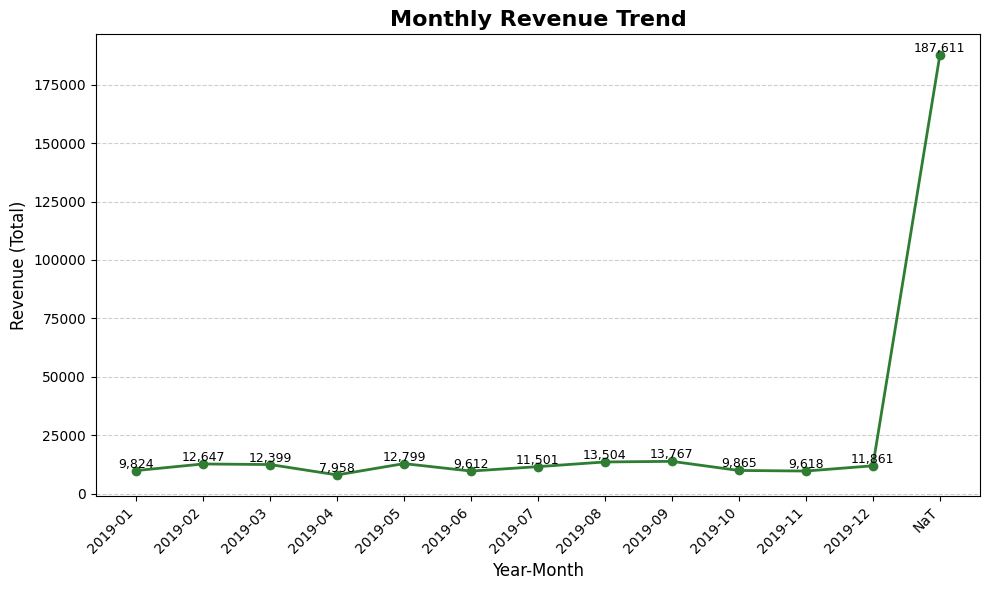

In [18]:
# Line chart with clean labels and a green corporate tone
m = aggs.get("monthly_revenue")
if m is not None and not m.empty:
    try:
        m["_ym"] = pd.to_datetime(m["year_month"], format="%Y-%m")
        m = m.sort_values("_ym")
    except Exception:
        pass

    plt.figure(figsize=(10, 6))
    plt.plot(m["year_month"], m["total"], marker="o", color=GREEN, linewidth=2)
    for x, y in zip(m["year_month"], m["total"]):
        plt.text(x, y, f"{y:,.0f}", ha="center", va="bottom", fontsize=9)
    plt.title("Monthly Revenue Trend", fontsize=16, fontweight="bold")
    plt.xlabel("Year-Month", fontsize=12)
    plt.ylabel("Revenue (Total)", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig("plot_monthly_revenue.png", dpi=150)
    plt.show()


## **Executive note:** Month-over-month revenue reveals momentum and seasonality. Peaks indicate strong commercial windows; troughs suggest demand gaps or operational constraints worth investigating.

## **Revenue by Product Line**

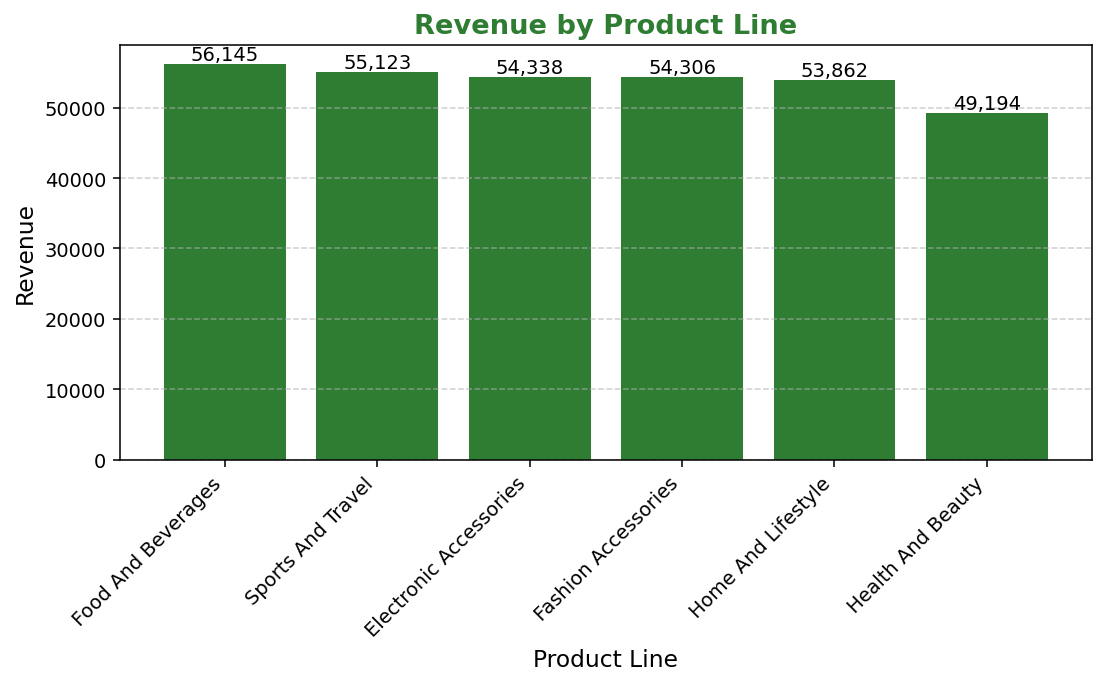

In [20]:
# Revenue by Product Line — medium size professional chart
import pandas as pd
import matplotlib.pyplot as plt

GREEN = "#2E7D32"

# Minimal safety: standardize needed columns
d = df.copy()
d.columns = (d.columns.astype(str)
             .str.replace(r"^\ufeff","", regex=True)
             .str.strip().str.lower().str.replace(" ","_").str.replace("%","pct"))
if "total" not in d.columns and "sales" in d.columns:
    d = d.rename(columns={"sales":"total"})

# Aggregate
p = (d.groupby("product_line", as_index=False)["total"].sum()
       .sort_values("total", ascending=False))

# Plot medium size
plt.figure(figsize=(8, 5), dpi=140)
ax = plt.gca()
ax.bar(p["product_line"], p["total"], color=GREEN)
for rect in ax.patches:
    h = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2, h, f"{h:,.0f}",
            ha="center", va="bottom", fontsize=10)
plt.title("Revenue by Product Line", fontsize=14, fontweight="bold", color=GREEN)
plt.xlabel("Product Line", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



## **Executive note**: Top product lines drive most revenue, showing strong customer preference. Lower performers may benefit from targeted marketing or repositioning.

# **Revenue by Payment Method**

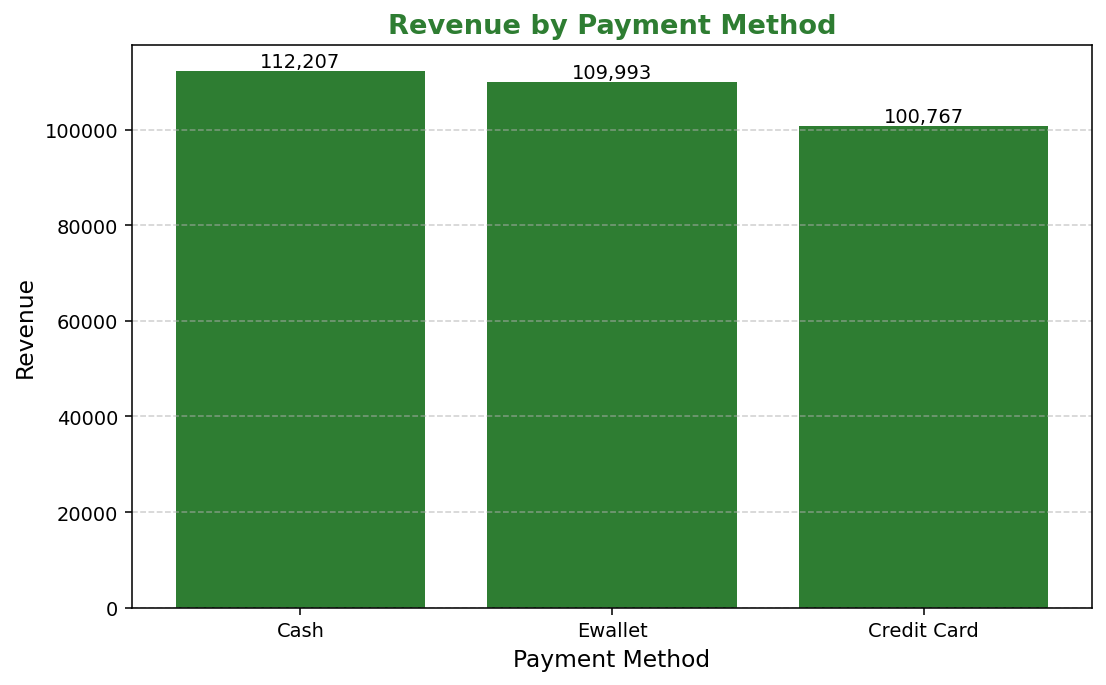

In [21]:
# Uses aggs if available; falls back to grouping on the fly
import pandas as pd
import matplotlib.pyplot as plt

GREEN = "#2E7D32"

try:
    pay = aggs["revenue_by_payment"].copy()
except:
    d = df.copy()
    d.columns = (d.columns.astype(str)
                 .str.replace(r"^\ufeff","", regex=True)
                 .str.strip().str.lower().str.replace(" ","_").str.replace("%","pct"))
    if "total" not in d.columns and "sales" in d.columns:
        d = d.rename(columns={"sales":"total"})
    pay = (d.groupby("payment", as_index=False)["total"].sum()) if {"payment","total"}.issubset(d.columns) else pd.DataFrame()

if not pay.empty:
    pay = pay.sort_values("total", ascending=False)
    plt.figure(figsize=(8, 5), dpi=140)
    ax = plt.gca()
    ax.bar(pay["payment"], pay["total"], color=GREEN)
    for rect in ax.patches:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, h, f"{h:,.0f}", ha="center", va="bottom", fontsize=10)
    plt.title("Revenue by Payment Method", fontsize=14, fontweight="bold", color=GREEN)
    plt.xlabel("Payment Method", fontsize=12); plt.ylabel("Revenue", fontsize=12)
    plt.xticks(fontsize=10); plt.yticks(fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout(); plt.show()
else:
    print("[SKIP] 'payment' or 'total' not available.")

## **Executive note:** Payment mix shows customer preference and potential friction. Dominant methods inform fee negotiations; underused options may signal awareness or UX gaps.

# **Revenue by City**

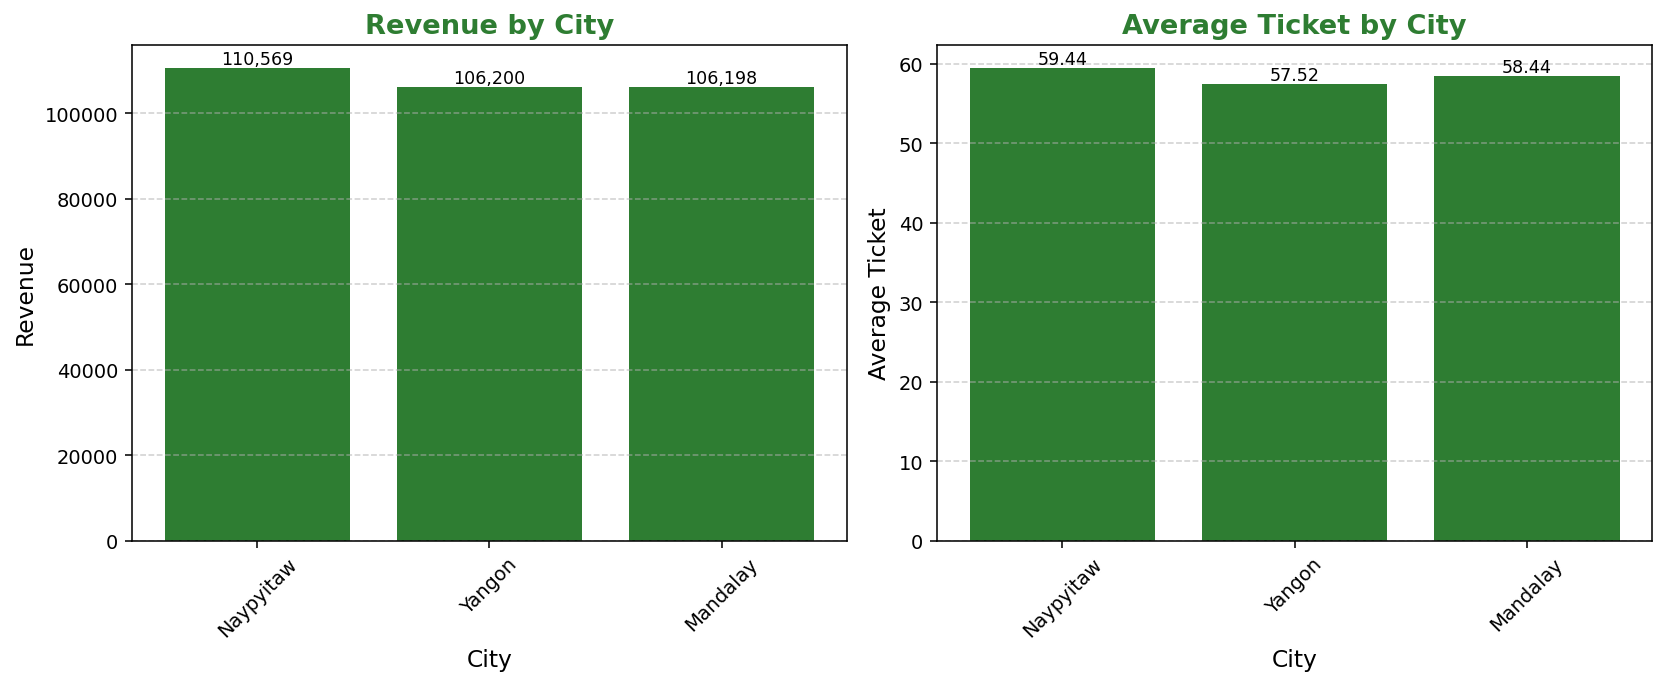

Executive note: Revenue is concentrated in Naypyitaw; cities with higher average tickets may justify premium positioning or targeted upsell.


In [27]:
# Side-by-side: Revenue by City + Average Ticket by City
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

GREEN = "#2E7D32"

# --- Safeguard / rebuild minimal dataset needed ---
try:
    city_df = aggs["revenue_by_city"].copy()
except:
    d = df.copy()
    d.columns = (d.columns.astype(str)
                 .str.replace(r"^\ufeff","", regex=True)
                 .str.strip().str.lower().str.replace(" ","_").str.replace("%","pct"))
    if "total" not in d.columns and "sales" in d.columns:
        d = d.rename(columns={"sales":"total"})
    # compute revenue by city
    if {"city","total"}.issubset(d.columns):
        city_df = d.groupby("city", as_index=False)["total"].sum()
    else:
        city_df = pd.DataFrame(columns=["city","total"])
# average ticket by city (needs quantity)
avg_ticket_df = pd.DataFrame()
if {"city","total","quantity"}.issubset(d.columns):
    tmp = d.copy()
    tmp["avg_ticket"] = tmp["total"] / tmp["quantity"].replace(0, pd.NA)
    avg_ticket_df = (tmp.groupby("city", as_index=False)["avg_ticket"]
                        .mean()
                        .sort_values("avg_ticket", ascending=False))

# --- Prepare plotting frames (sorted) ---
city_df = city_df.sort_values("total", ascending=False)
# Align cities between both charts if both exist
if not avg_ticket_df.empty:
    common = city_df["city"].tolist()  # keep revenue order
    avg_ticket_df = avg_ticket_df.set_index("city").reindex(common).reset_index()

# --- Plot side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=140)

# Left: Revenue by City
ax = axes[0]
if not city_df.empty:
    ax.bar(city_df["city"], city_df["total"], color=GREEN)
    for rect in ax.patches:
        h = rect.get_height()
        if np.isfinite(h):
            ax.text(rect.get_x()+rect.get_width()/2, h, f"{h:,.0f}",
                    ha="center", va="bottom", fontsize=9)
    ax.set_title("Revenue by City", fontsize=14, fontweight="bold", color=GREEN)
    ax.set_xlabel("City", fontsize=12); ax.set_ylabel("Revenue", fontsize=12)
    ax.tick_params(axis="x", labelrotation=45)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
else:
    ax.text(0.5, 0.5, "No data", ha="center", va="center"); ax.axis("off")

# Right: Average Ticket by City
ax2 = axes[1]
if not avg_ticket_df.empty:
    ax2.bar(avg_ticket_df["city"], avg_ticket_df["avg_ticket"], color=GREEN)
    for rect in ax2.patches:
        h = rect.get_height()
        if np.isfinite(h):
            ax2.text(rect.get_x()+rect.get_width()/2, h, f"{h:,.2f}",
                     ha="center", va="bottom", fontsize=9)
    ax2.set_title("Average Ticket by City", fontsize=14, fontweight="bold", color=GREEN)
    ax2.set_xlabel("City", fontsize=12); ax2.set_ylabel("Average Ticket", fontsize=12)
    ax2.tick_params(axis="x", labelrotation=45)
    ax2.grid(axis="y", linestyle="--", alpha=0.6)
else:
    ax2.text(0.5, 0.5, "No data", ha="center", va="center"); ax2.axis("off")

plt.tight_layout()
plt.show()

# --- Short executive note (plain text) ---
if not city_df.empty:
    top_city = city_df.iloc[0]["city"]
    note = f"Executive note: Revenue is concentrated in {top_city}; cities with higher average tickets may justify premium positioning or targeted upsell."
    print(note)
else:
    print("Executive note: Not enough city-level data to summarize.")


## **Executive note:** Revenue is concentrated in the top-performing city, indicating a strong market presence there. Cities with higher average tickets may reflect stronger purchasing power or effective upselling strategies.

# **Evolution of Payment Preferences**

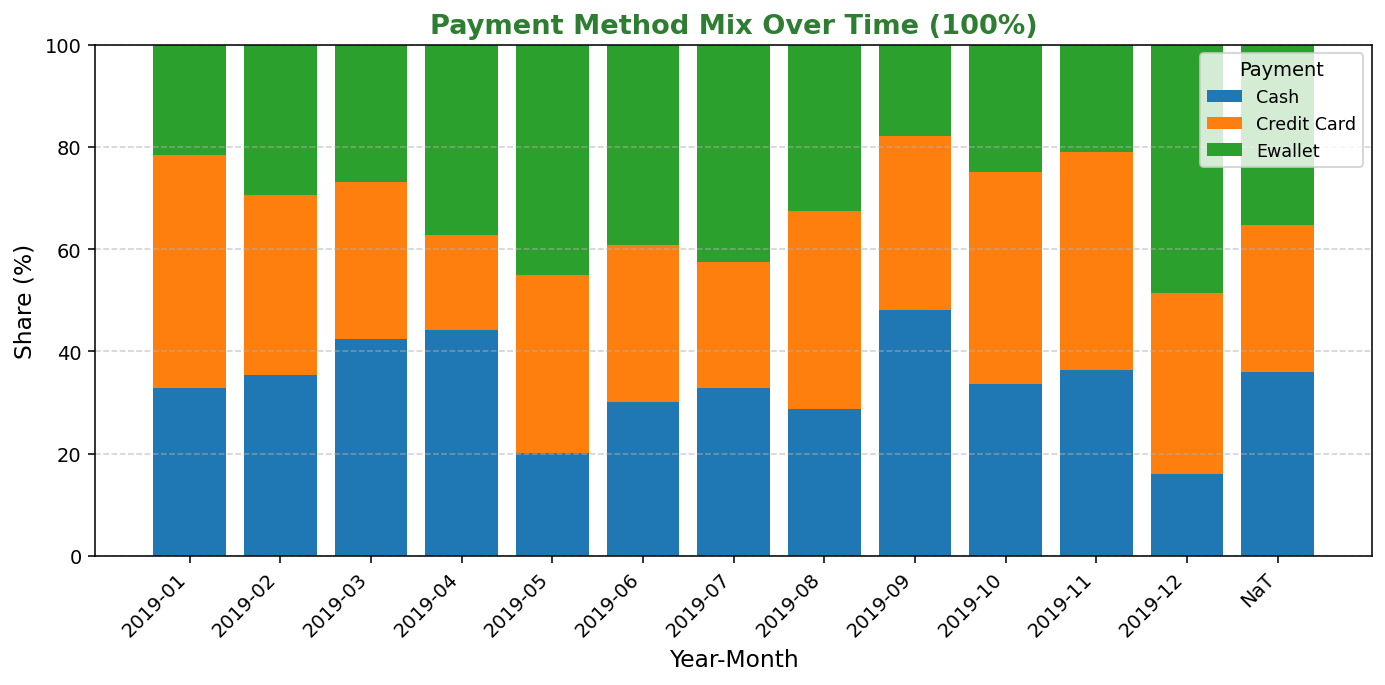

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

GREEN = "#2E7D32"

# Copia e limpa nomes de colunas
d = df.copy()
d.columns = (d.columns.astype(str)
             .str.replace(r"^\ufeff", "", regex=True)
             .str.strip().str.lower().str.replace(" ", "_").str.replace("%", "pct"))

# Ajusta 'sales' para 'total' se necessário
if "total" not in d.columns and "sales" in d.columns:
    d = d.rename(columns={"sales": "total"})

# Converte data e cria coluna ano-mês
d["date"] = pd.to_datetime(d["date"], errors="coerce", dayfirst=True)
d["year_month"] = d["date"].dt.to_period("M").astype(str)

# Calcula porcentagem por método de pagamento
mix = (d.groupby(["year_month", "payment"])["total"].sum()
         .unstack(fill_value=0).sort_index())
mix_pct = mix.div(mix.sum(axis=1), axis=0) * 100

# Plota gráfico de barras empilhadas 100%
plt.figure(figsize=(10, 5), dpi=140)
bottom = np.zeros(len(mix_pct))
for col in mix_pct.columns:
    plt.bar(mix_pct.index, mix_pct[col], bottom=bottom, label=str(col))
    bottom += mix_pct[col].values

plt.title("Payment Method Mix Over Time (100%)", fontsize=14, fontweight="bold", color=GREEN)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Share (%)", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Payment", fontsize=9)
plt.tight_layout()
plt.show()




# **Executive note:** Tracking the evolution of payment preferences highlights shifts in customer behavior. Emerging methods may signal opportunities for innovation, while declining ones may require improved incentives or support.

# **Revenue & Average Ticket by Customer Type**

# **Pareto — Revenue by Product Line (ABC)**

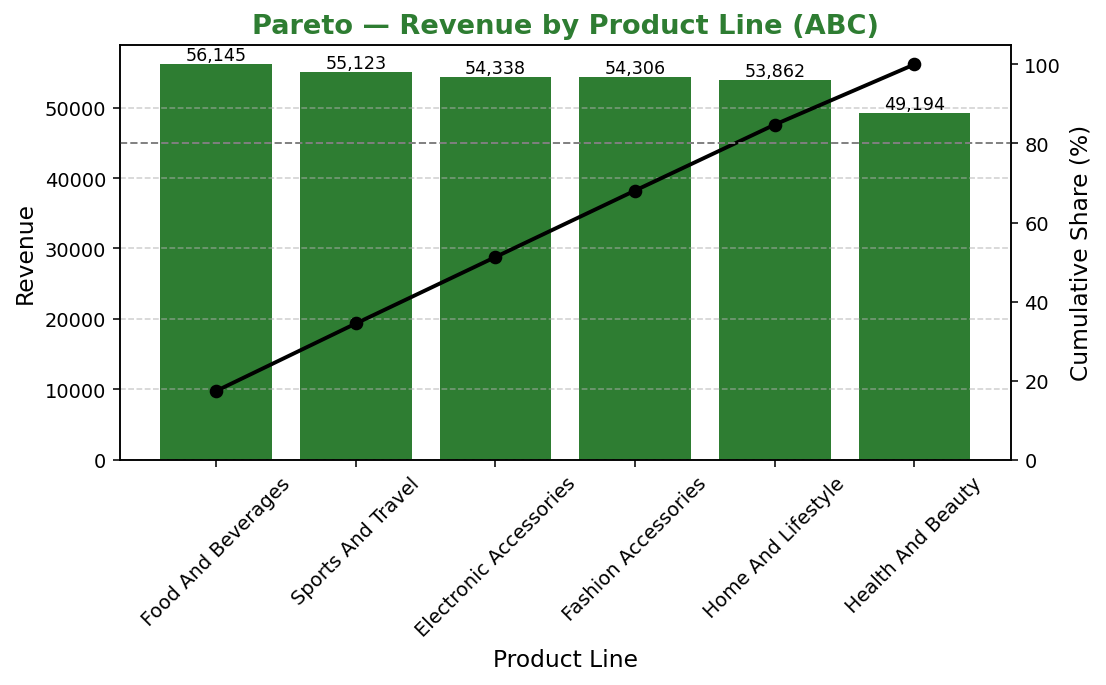

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

GREEN = "#2E7D32"

# Copia e limpa nomes de colunas
d = df.copy()
d.columns = (d.columns.astype(str)
             .str.replace(r"^\ufeff", "", regex=True)
             .str.strip().str.lower()
             .str.replace(" ", "_")
             .str.replace("%", "pct"))

# Ajusta nome de coluna de vendas
if "total" not in d.columns and "sales" in d.columns:
    d = d.rename(columns={"sales": "total"})

# Ajusta nome de coluna de produto
if "product_line" not in d.columns:
    # Tenta identificar pelo conteúdo
    possible_cols = [c for c in d.columns if "product" in c and "line" in c]
    if possible_cols:
        d = d.rename(columns={possible_cols[0]: "product_line"})

# Gera Pareto se colunas existirem
if {"product_line", "total"}.issubset(d.columns):
    # Remove NaNs e soma receita por linha de produto
    pareto = (d.dropna(subset=["product_line", "total"])
                .groupby("product_line", as_index=False)["total"].sum()
                .sort_values("total", ascending=False))

    # Calcula % acumulado
    pareto["cum_share"] = pareto["total"].cumsum() / pareto["total"].sum() * 100

    # Cria figura
    fig, ax1 = plt.subplots(figsize=(8, 5), dpi=140)

    # Barras
    ax1.bar(pareto["product_line"], pareto["total"], color=GREEN)
    for r in ax1.patches:
        h = r.get_height()
        if np.isfinite(h):
            ax1.text(r.get_x()+r.get_width()/2, h, f"{h:,.0f}",
                     ha="center", va="bottom", fontsize=9)
    ax1.set_xlabel("Product Line", fontsize=12)
    ax1.set_ylabel("Revenue", fontsize=12)
    ax1.tick_params(axis="x", labelrotation=45)
    ax1.grid(axis="y", linestyle="--", alpha=0.6)
    ax1.set_title("Pareto — Revenue by Product Line (ABC)", fontsize=14,
                  fontweight="bold", color=GREEN)

    # Linha de % acumulado
    ax2 = ax1.twinx()
    ax2.plot(pareto["product_line"], pareto["cum_share"], marker="o",
             linewidth=2, color="black")
    ax2.set_ylabel("Cumulative Share (%)", fontsize=12)
    ax2.set_ylim(0, 105)
    ax2.axhline(80, color="gray", linestyle="--", linewidth=1)

    plt.tight_layout()
    plt.show()
else:
    print("[SKIP] Missing 'product_line' or 'total' column even after cleaning.")



## **Executive note:** Revenue distribution follows the Pareto principle, where a small number of product lines generate the majority of sales. Prioritizing these top performers can maximize returns, while targeted strategies for lower-performing categories may unlock untapped potential.